# packages

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

# load data

In [18]:
df = pd.read_csv(r'data\raw_final_df2.txt', sep='\t')
df = df[df['gene_biotype']=='protein_coding']
df1 = df.drop(['gene_biotype','num_enhancers'], axis=1)
df1['log_ae'] = np.log(df1['Avg_VG_AE'])
df1['log_eqtl'] = np.log(df1['Avg_VG_eQTL'])
df1 = df1[df1['Avg_VG_AE'].notna()]
df1 = df1.drop(['Avg_VG_AE','Avg_VG_eQTL'], axis=1)
df1 = df1.drop_duplicates('ensembl_gene_id')
df1.reset_index(drop=True, inplace=True)
df1.columns

Index(['ensembl_gene_id', 'loeuf_score', 'ncGERP', 'ncRVIS', 'RVIS_score',
       'ncCADD', 'median_tpm', 'num_enh', 'num_super_enh', 'pHaplo', 'pTriplo',
       'Episcore', 'pLI', 'tau', 'log_ae', 'log_eqtl'],
      dtype='object')

# PCA

In [19]:
# n_components = 10
best_df = df1.dropna().reset_index(drop=True)
pca = PCA()
pca_pipe = Pipeline([('scaler',StandardScaler()),('pca', pca)]) #
X_pca = best_df.drop(['ensembl_gene_id','log_ae'], axis=1)
y_pca = best_df['log_ae']
PC = pca_pipe.fit_transform(X_pca)
n_components = len(pca.components_)
pca_df = pd.DataFrame(data=PC, columns = ['principal component {}'.format(i+1) for i in range(n_components) ])
pca_df['log_ae'] =  y_pca
pca_df['ensembl_gene_id'] = best_df['ensembl_gene_id']


## Fig. 3

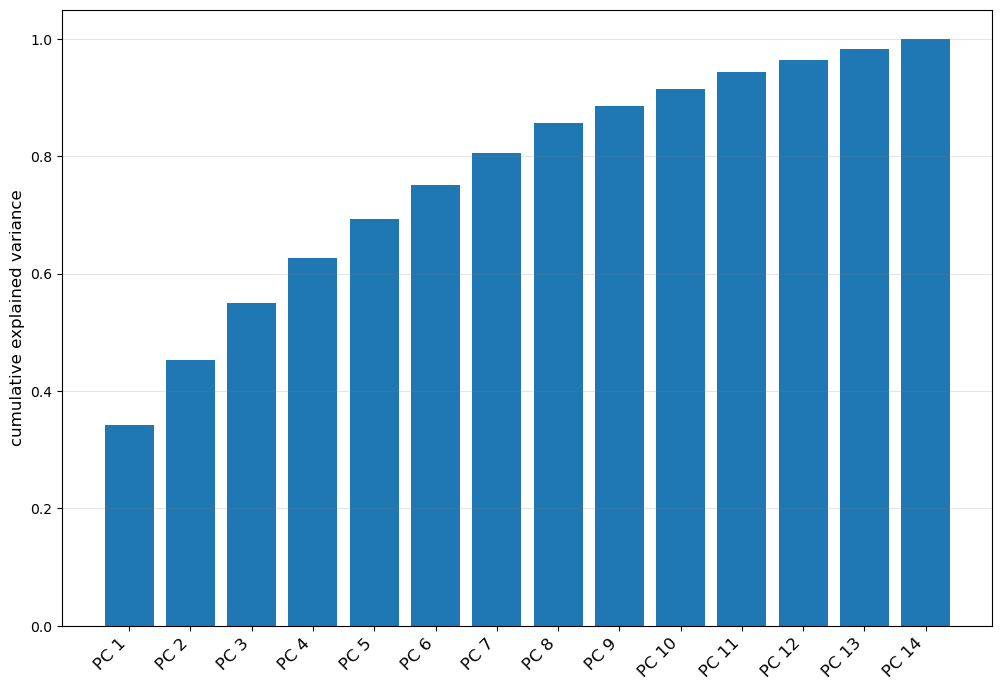

14 14


In [20]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
cumulative_variance = list(cumulative_variance)
pcs = ['PC {}'.format(i+1) for i in range(n_components)]
plt.figure(figsize = (12,8))
plt.bar(pcs, cumulative_variance)
plt.xticks(rotation=45, fontsize = 12, ha='right')
# plt.xlabel('tissue')
plt.ylabel('cumulative explained variance', fontsize=12)
plt.grid(axis='y', color='grey', alpha=0.2)
# plt.savefig(r'datacollection\images\final_report\PCA_cumulative_variance.png', dpi = 600)
# plt.savefig(r'datacollection\images\final_report\PCA_cumulative_variance.svg', dpi = 96, bbox_inches='tight')
plt.show()
print(len(cumulative_variance), len(pcs))

# Venn Diagram:

## Fig. 4A
* how many values do we have how many can we possibly predict

(22895, 16)
(12235,)
(12807,)


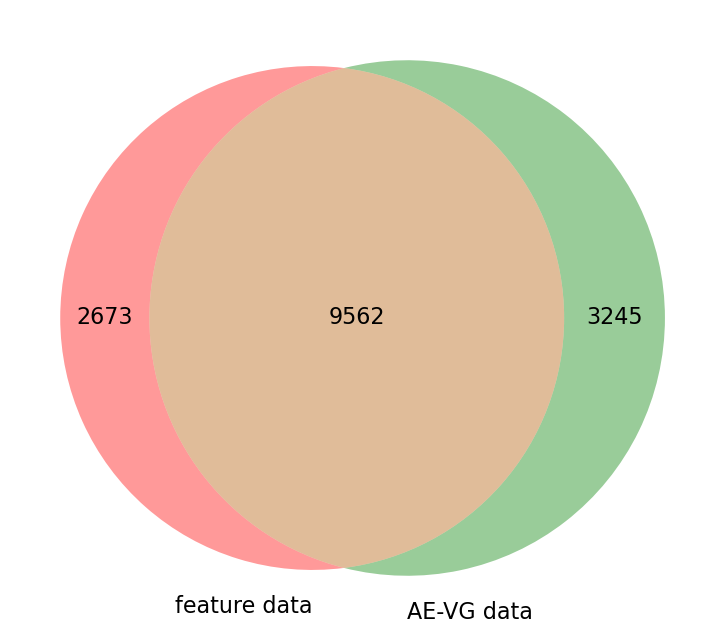

In [24]:
#filter for those rows where you have no NA except for NA in log_AE
from matplotlib_venn import venn2


venn_df = df[df['gene_biotype']=='protein_coding'].drop(['gene_biotype','num_enhancers'], axis=1)
venn_df['log_ae'] = np.log(df['Avg_VG_AE'])
venn_df['log_eqtl'] = np.log(df['Avg_VG_eQTL'])
venn_df = venn_df.drop(['Avg_VG_AE','Avg_VG_eQTL'], axis=1)

venn_df = venn_df.drop_duplicates('ensembl_gene_id')
venn_df.reset_index(drop=True, inplace=True)
print(venn_df.shape)
metric_df = venn_df.drop('log_ae',axis=1).dropna()
metric_df = metric_df.loc[:,'ensembl_gene_id']
print(metric_df.shape)
aes = venn_df.loc[:,['ensembl_gene_id','log_ae']].dropna()
aes = aes.loc[:,'ensembl_gene_id']
print(aes.shape)
plt.figure(figsize=(12,8))
venn = venn2([set(metric_df), set(aes)],['feature data','AE-VG data'])
venn
for label in venn.set_labels:
    label.set_fontsize(16)
for label in venn.subset_labels:
    label.set_fontsize(16)
# plt.savefig(r'datacollection\images\final_report\avg_venn_before.png', dpi = 300)
# plt.savefig(r'datacollection\images\final_report\avg_venn_before.svg', dpi=96, bbox_inches='tight')

# print(df.notna().sum(),'\n', df1.shape)



# KNN Imputation

In [28]:
def count_na(x):
    count = 0 
    for i in x: #iterate over the rows of a df. i is a row value (i.e. a field)
        
        if pd.isna(i):
            count += 1 #if a NA is encountered 
    return count 


In [29]:
df = pd.read_csv(r'data\raw_final_df2.txt', sep='\t')
df1 = df[df['gene_biotype']=='protein_coding'].drop(['gene_biotype','num_enhancers'], axis=1) #most of the genetic constraint metrics almost only exist for protein coding genes, so filter the protein_coding genes
df1['log_ae'] = np.log(df1['Avg_VG_AE'])
df1['log_eqtl'] = np.log(df1['Avg_VG_eQTL'])
df1 = df1.drop(['Avg_VG_eQTL','Avg_VG_AE'], axis=1)
df1 = df1.drop_duplicates('ensembl_gene_id')
df1['na_count'] = df1.apply(lambda x: count_na(x[:]), axis=1)
cond = df1.log_eqtl.isna() &  df1.tau.isna() & df1.median_tpm.isna() # boolean for the rows where GTEx v7 data was incomplete and/or the scores have not been calculated  
df1 = df1.loc[~cond,:] # exclude those genes where we have no the GTEx data
df1 = df1[df1['na_count']<=5] #exclude those genes where we have more than 5 features missing
df1.set_index('ensembl_gene_id', inplace=True)


X_train = df1.drop(['log_ae','na_count'], axis = 1)
features = list(X_train.columns)
X_train = np.array(X_train)
y = np.array(df1['log_ae'])
pipe = Pipeline([('imputer',KNNImputer(n_neighbors=5, weights='uniform'))])#
X_imputed_train = pipe.fit_transform(X_train)
imputed_train = pd.DataFrame(X_imputed_train, columns = features)
imputed_train['log_ae'] = y
imputed_train.index = df1.index
imputed_train.reset_index(inplace=True) # this makes ensembl_gene_id the first column
imputed_train['gene_biotype'] = 'protein_coding'
print(imputed_train.head())

imputed_train.to_csv(r'data\imputed_ML_df.csv',sep='\t',index=False)


   ensembl_gene_id  loeuf_score    ncGERP    ncRVIS  RVIS_score    ncCADD  \
0  ENSG00000102699        0.837 -0.513691  0.090132    4.627272  5.991149   
1  ENSG00000027001        1.035 -0.275592 -0.342196    0.624650  6.642385   
2  ENSG00000102781        0.439 -0.333999  2.350715   -0.159705  5.639629   
3  ENSG00000133101        0.680  0.355963  0.377395   -0.492218  7.921371   
4  ENSG00000132952        0.456  0.965914 -0.603996    0.453744  9.363447   

   median_tpm  num_enh  num_super_enh    pHaplo   pTriplo  Episcore  \
0     23.8300     59.0            0.0  0.350075  0.332723  0.222067   
1      8.7450      0.0            0.0  0.371589  0.589904  0.221000   
2      5.9810     91.0            1.0  0.414764  0.715844  0.546933   
3      0.6567      0.0            0.0  0.294731  0.301389  0.577117   
4     15.6100    136.0            3.0  0.706093  0.555769  0.809633   

            pLI       tau  log_eqtl    log_ae    gene_biotype  
0  4.820400e-27  0.183037 -6.507604 -5.486193 

## Fig. 4B
* venn after imputation

(22895, 16)
(16957,)
(12807,)


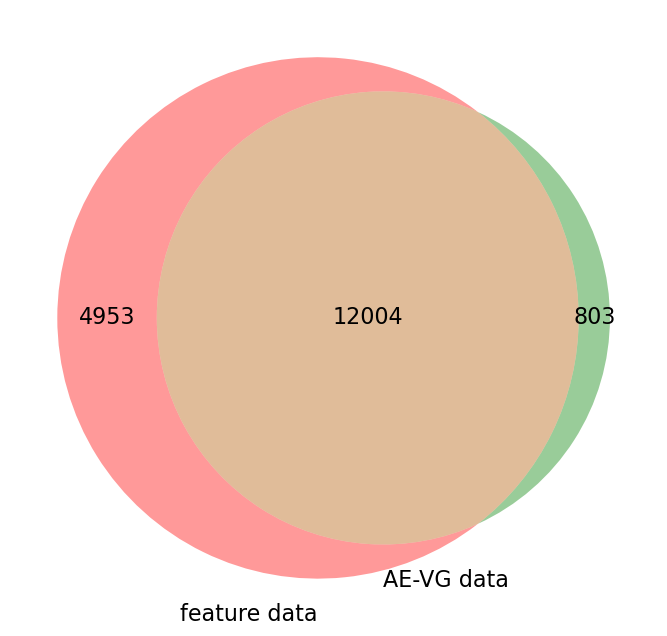

In [30]:
imputed_df = pd.read_csv(r'data\imputed_ML_df.csv', sep='\t')

venn_df = df[df['gene_biotype']=='protein_coding'].drop(['gene_biotype','num_enhancers'], axis=1)
venn_df['log_ae'] = np.log(df['Avg_VG_AE'])
venn_df['log_eqtl'] = np.log(df['Avg_VG_eQTL'])
venn_df = venn_df.drop(['Avg_VG_AE','Avg_VG_eQTL'], axis=1)
venn_df = venn_df.drop_duplicates('ensembl_gene_id')
venn_df.reset_index(drop=True, inplace=True)
print(venn_df.shape)
metric_df = imputed_df.drop('log_ae',axis=1).dropna()
metric_df = imputed_df.loc[:,'ensembl_gene_id']
print(metric_df.shape)
aes = venn_df.loc[:,['ensembl_gene_id','log_ae']].dropna()
aes = aes.loc[:,'ensembl_gene_id']
print(aes.shape)
plt.figure(figsize=(12,8))
venn = venn2([set(metric_df), set(aes)],['feature data','AE-VG data'])
for label in venn.set_labels:
    label.set_fontsize(16)
for label in venn.subset_labels:
    label.set_fontsize(16)
venn
# plt.savefig(r'datacollection\images\final_report\avg_venn_after.png', dpi = 300)
# plt.savefig(r'datacollection\images\final_report\avg_venn_after.svg', dpi=96, bbox_inches='tight')
